In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm

import multitask.dataset as dataset
import multitask.models.parallel.hooks as hooks
from multitask.models.parallel import get_parallel_model
from multitask.representations import get_mean_activations, calculate_sm, plot_sm
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs

ImportError: cannot import name 'calculate_sm' from 'multitask.representations' (/Users/sgalella/miniconda3/envs/multitask/lib/python3.8/site-packages/multitask/representations/__init__.py)

In [ ]:
path_data = os.path.join('..', '..', 'data')
path_figure_digits_2 = os.path.join('svg', 'figureS20_sm_empirical_parallel_digits_2.svg')
path_figure_digits_5 = os.path.join('svg', 'figureS20_sm_empirical_parallel_digits_5.svg')
path_figure_letters_2 = os.path.join('svg', 'figureS20_sm_empirical_parallel_letters_2.svg')
path_model_parallel = os.path.join('..', '..', 'results', 'parallel')


## 2 Digit Tasks

In [ ]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 50
num_hidden = 10 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value']
idxs_contexts = None

In [ ]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': idxs_contexts
}

data_folder = check_runs(path_model_parallel, parameters)

Found simulation in ../../results/parallel with the same parameters (2022-09-28_01_56_10)


In [ ]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_parallel = pickle.load(handle)

In [ ]:
seeds = sorted(list(results_parallel.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value']


In [ ]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

In [ ]:
parallel_datasets = {}
for task_name in tasks_names:
    parallel_datasets[task_name] = tasks_datasets[task_name]

parallel_tasks = dataset.MultilabelTasks(parallel_datasets)

In [ ]:
device = get_device()
criterion = nn.CrossEntropyLoss()
num_layers = len(num_hidden)
num_tasks = len(tasks_names)
list_sm = []

for i_seed, seed in tqdm(enumerate(seeds), total=num_runs):
    state_dict = results_parallel[seed]['model']
    model = get_parallel_model(num_tasks,
                               num_hidden,
                               device)

    model.load_state_dict(state_dict)
    
    indices = results_parallel[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    parallel_testloader = torch.utils.data.DataLoader(parallel_tasks,
                                                      sampler=test_sampler,
                                                      batch_size=batch_size)

    numbers = parallel_datasets[tasks_names[0]].numbers.numpy()
    numbers = numbers[indices['test']]
    
    _, activations = hooks.get_layer_activations(model,
                                                 parallel_testloader,
                                                 criterion=criterion,
                                                 device=device,
                                                 disable=True)
    
    task_activations = []
    task_numbers = []
    
    for task_name in tasks_names:
        task_activations.append(activations)
        task_numbers.append(numbers)

    mean_activations = get_mean_activations(task_activations,
                                            num_hidden,
                                            list_labels=task_numbers,
                                            tasks_names=tasks_names)

    sm_dict = calculate_sm(mean_activations,
                             tasks_names=tasks_names)


    list_sm.append(sm_dict)

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
mean_sm_2_digits = {}

for layer in range(num_layers):
    mean_sm_2_digits[layer+1] = np.zeros((num_tasks * 10, num_tasks * 10))
    for rdm in list_sm:
        mean_sm_2_digits[layer+1] += rdm[layer+1]
    mean_sm_2_digits[layer+1] /= num_runs

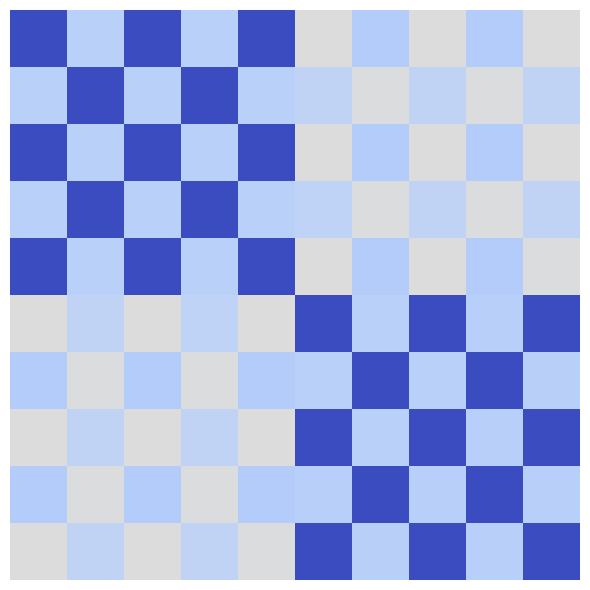

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.imshow(mean_sm_2_digits[10][:10, :10], cmap='coolwarm_r', vmin=-1, vmax=1)
ax.axis('off')

fig.tight_layout()
fig.savefig(path_figure_digits_2)
plt.show()

## 5 Digit Tasks

In [ ]:
initial_seed = 6789
tasks_names = ['parity', 'value', 'prime', 'fibonacci', 'multiples3']

parameters['initial_seed'] = initial_seed
parameters['tasks'] = tasks_names

data_folder = check_runs(path_model_parallel, parameters)

Found simulation in ../../results/parallel with the same parameters (2022-09-28_05_54_25)


In [ ]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_parallel = pickle.load(handle)

In [ ]:
seeds = sorted(list(results_parallel.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value', 'prime', 'fibonacci', 'multiples3']


In [ ]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

In [ ]:
parallel_datasets = {}
for task_name in tasks_names:
    parallel_datasets[task_name] = tasks_datasets[task_name]

parallel_tasks = dataset.MultilabelTasks(parallel_datasets)

In [ ]:
device = get_device()
criterion = nn.CrossEntropyLoss()
num_layers = len(num_hidden)
num_tasks = len(tasks_names)
list_sm = []

for i_seed, seed in tqdm(enumerate(seeds), total=num_runs):
    state_dict = results_parallel[seed]['model']
    model = get_parallel_model(num_tasks,
                               num_hidden,
                               device)

    model.load_state_dict(state_dict)
    
    indices = results_parallel[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    parallel_testloader = torch.utils.data.DataLoader(parallel_tasks,
                                                      sampler=test_sampler,
                                                      batch_size=batch_size)

    numbers = parallel_datasets[tasks_names[0]].numbers.numpy()
    numbers = numbers[indices['test']]
    
    _, activations = hooks.get_layer_activations(model,
                                                 parallel_testloader,
                                                 criterion=criterion,
                                                 device=device,
                                                 disable=True)
    
    task_activations = []
    task_numbers = []
    
    for task_name in tasks_names:
        task_activations.append(activations)
        task_numbers.append(numbers)

    mean_activations = get_mean_activations(task_activations,
                                            num_hidden,
                                            list_labels=task_numbers,
                                            tasks_names=tasks_names)

    sm_dict = calculate_sm(mean_activations,
                             tasks_names=tasks_names)


    list_sm.append(sm_dict)

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
mean_sm_5_digits = {}

for layer in range(num_layers):
    mean_sm_5_digits[layer+1] = np.zeros((num_tasks * 10, num_tasks * 10))
    for rdm in list_sm:
        mean_sm_5_digits[layer+1] += rdm[layer+1]
    mean_sm_5_digits[layer+1] /= num_runs

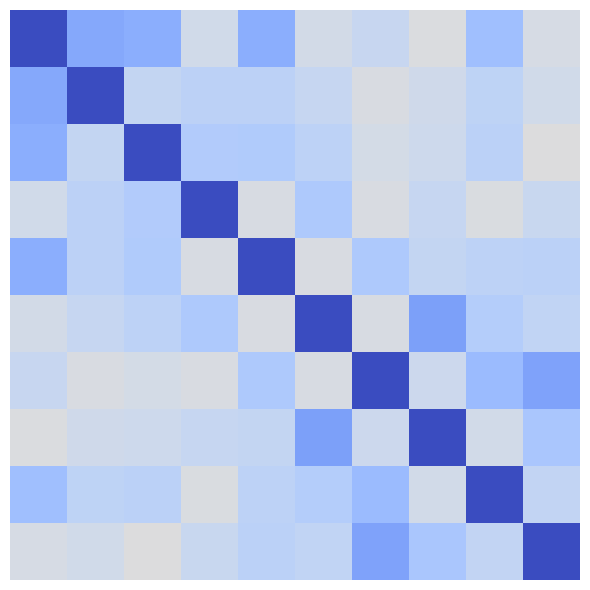

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.imshow(mean_sm_5_digits[10][:10, :10], cmap='coolwarm_r', vmin=-1, vmax=1)
ax.axis('off')

fig.tight_layout()
fig.savefig(path_figure_digits_5)
plt.show()

## 2 Letter Tasks

In [ ]:
initial_seed = 1234
tasks_names = ['vowel', 'position']
num_train = 41080
num_test = 8216

parameters['initial_seed'] = initial_seed
parameters['tasks'] = tasks_names
parameters['num_train'] = num_train
parameters['num_test'] = num_test

data_folder = check_runs(path_model_parallel, parameters)

Found simulation in ../../results/parallel with the same parameters (2024-01-12_18-33-14)


In [ ]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_parallel = pickle.load(handle)

In [ ]:
seeds = sorted(list(results_parallel.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[165158, 220532, 318129, 451283, 486191, 514041, 818831, 869016, 908341, 978124]
['vowel', 'position']


In [ ]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

In [ ]:
parallel_datasets = {}
for task_name in tasks_names:
    parallel_datasets[task_name] = tasks_datasets[task_name]

parallel_tasks = dataset.MultilabelTasks(parallel_datasets)

In [ ]:
device = get_device()
criterion = nn.CrossEntropyLoss()
num_layers = len(num_hidden)
num_tasks = len(tasks_names)
list_sm = []

for i_seed, seed in tqdm(enumerate(seeds), total=num_runs):
    state_dict = results_parallel[seed]['model']
    model = get_parallel_model(num_tasks,
                               num_hidden,
                               device)

    model.load_state_dict(state_dict)
    
    indices = results_parallel[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    parallel_testloader = torch.utils.data.DataLoader(parallel_tasks,
                                                      sampler=test_sampler,
                                                      batch_size=batch_size)

    letters = parallel_datasets[tasks_names[0]].letters.numpy()
    letters = letters[indices['test']]
    
    _, activations = hooks.get_layer_activations(model,
                                                 parallel_testloader,
                                                 criterion=criterion,
                                                 device=device,
                                                 disable=True)
    
    task_activations = []
    task_letters = []
    
    for task_name in tasks_names:
        task_activations.append(activations)
        task_letters.append(letters)

    mean_activations = get_mean_activations(task_activations,
                                            num_hidden,
                                            list_labels=task_letters,
                                            tasks_names=tasks_names)

    sm_dict = calculate_sm(mean_activations,
                           tasks_names=tasks_names)


    list_sm.append(sm_dict)

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
mean_sm_2_letters = {}

for layer in range(num_layers):
    mean_sm_2_letters[layer+1] = np.zeros((num_tasks * 26, num_tasks * 26))
    for rdm in list_sm:
        mean_sm_2_letters[layer+1] += rdm[layer+1]
    mean_sm_2_letters[layer+1] /= num_runs

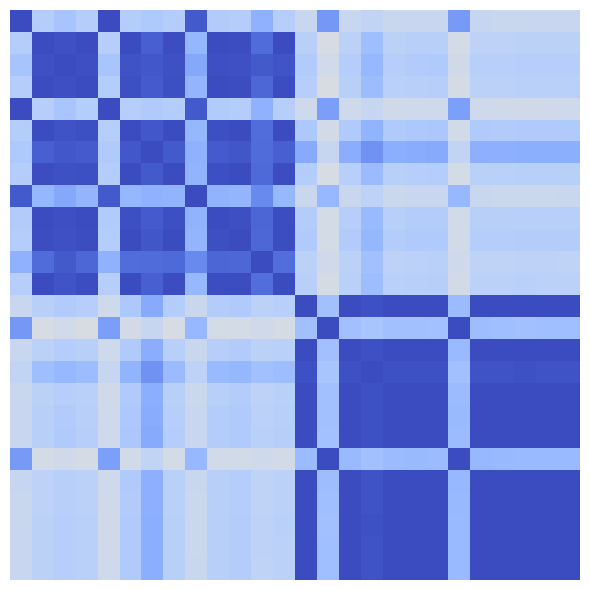

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.imshow(mean_sm_2_letters[10][:26, :26], cmap='coolwarm_r', vmin=-1, vmax=1)
ax.axis('off')

fig.tight_layout()
fig.savefig(path_figure_letters_2)
plt.show()